In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

<AxesSubplot:>

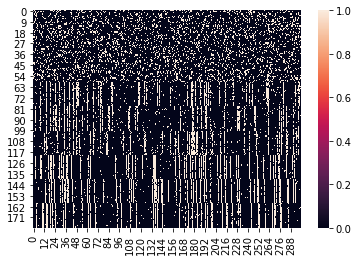

In [10]:
n_neurons = 180
t_max = 500
n_populations = 9
permute = True
time_shifts = [0, 0, 0, 0, 0, 0, 1, 2, 3]
neuron_population_correlation = [0, .8, .8, .8, .8, .8, .9, .9, .9]
population_correlations = [0, .6, .6, .6, .6, .6, .9, .9, .9]
mean_firing_rate = 0.2

n_neurons_pop = int(n_neurons / n_populations)

spikes = np.zeros((n_neurons, t_max))

# population 1 - 3: uncorrelated
spikes[:n_neurons_pop*3, :] = np.random.poisson(lam=mean_firing_rate, size=(n_neurons_pop*3, t_max))

# population 4 - 6: correlated
poisson_grandmother_train1 = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))
poisson_grandmother_train2 = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))

poisson_mother_trains = np.zeros((n_populations, t_max))
for i in range(3, 9):

    delete_spikes = population_correlations[i] * np.ones((1, t_max)) <= np.random.uniform(0, 1, size=(1, t_max))
    noise = np.random.poisson((1 - population_correlations[i]) * mean_firing_rate, (1, t_max))
    if i <= 5:
        poisson_mother_trains[i] = poisson_grandmother_train1 - (delete_spikes * poisson_grandmother_train1) + noise
    else:
        poisson_mother_trains[i] = poisson_grandmother_train2 - (delete_spikes * poisson_grandmother_train2) + noise
    poisson_mother_trains[i] = np.roll(poisson_mother_trains[i], time_shifts[i])  # add time shifts

    # neuron dynamics
    delete_spikes = neuron_population_correlation[i] * np.ones((n_neurons_pop, t_max)) <= \
                    np.random.uniform(0, 1, size=(n_neurons_pop, t_max))
    noise = np.random.poisson((1 - neuron_population_correlation[i]) * mean_firing_rate, (n_neurons_pop, t_max))
    population_spikes = np.tile(poisson_mother_trains[i], (n_neurons_pop, 1))
    population_spikes = population_spikes - (delete_spikes * population_spikes) + noise

    idx = np.arange(n_neurons_pop) + i * n_neurons_pop
    spikes[idx, :] = population_spikes
    
# make binary
spikes[spikes < 0] = 0
spikes[spikes > 1] = 1

# create 2 dimensional brain-space locations for all neuron populations
mean_locations_pop = [[-1, 1], [0, 1], [1, 1], [-1, 0], [0, 0], [1, 0], [-1, -1], [0, -1], [1, -1]]
neuron_coordinates = np.zeros((n_neurons, 2))
for i in range(n_populations):
    neuron_coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.25 * np.random.randn(n_neurons_pop, 2) + \
                                                                       mean_locations_pop[i]


populations_idx = np.arange(n_neurons, dtype=int)
data = torch.tensor(spikes, dtype=torch.float)
sns.heatmap(data[:, 200:500])

In [3]:
def mse(x, y):
    return torch.mean((x - y)**2)

In [12]:
from tqdm.notebook import tqdm


n_epochs = 5000
N_V = 180
T = 500
N_H = 10


rtrbm = RTRBM(data, N_H=N_H, device='cpu')

W = torch.zeros(N_H, N_V)
W_acc = torch.zeros(N_H, N_H)
dW_mean = torch.zeros(n_epochs)
dW_acc_mean = torch.zeros(n_epochs)
dW_std = torch.zeros(n_epochs)
dW_acc_std = torch.zeros(n_epochs)
v_contribution_r = torch.zeros(n_epochs, N_H)
h_contribution_r = torch.zeros(n_epochs, N_H)
v_contribution_p = torch.zeros(n_epochs, N_H)
h_contribution_p = torch.zeros(n_epochs, N_H)
bias = torch.zeros(n_epochs, N_H)
v_infer = torch.zeros(n_epochs, N_V, T)
r_infer = torch.zeros(n_epochs, N_H, T)
r = torch.zeros(n_epochs, N_H, T)

dW = torch.zeros(n_epochs, N_H, N_V)
dW_acc = torch.zeros(n_epochs, N_H, N_H)
db_H = torch.zeros(n_epochs, N_H)
db_V = torch.zeros(n_epochs, N_V)
vt_k = torch.zeros(n_epochs, N_V, T)
barvt = torch.zeros(n_epochs, N_V, T)
db_init = torch.zeros(n_epochs, N_H)
v_rec_error = torch.zeros(n_epochs)
r_rec_error = torch.zeros(n_epochs)
errors = []
W = torch.zeros(n_epochs, N_H, N_V)
W_acc = torch.zeros(n_epochs, N_H, N_H)

for epoch in tqdm(range(n_epochs)):
    
    rtrbm.learn(n_epochs=1, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0, disable_tqdm=True)
    
    dW[epoch :, :], dW_acc[epoch, :, :], db_H[epoch, :], db_V[epoch, :], db_init[epoch, :] = rtrbm.dparams

    rt = torch.zeros(rtrbm.N_H, rtrbm.T, dtype=torch.float)
    rt[:, 0] = torch.sigmoid(torch.matmul(rtrbm.W, data[:, 0]) + rtrbm.b_init)
    v_contribution_r += torch.mean(torch.matmul(rtrbm.W, rtrbm.V[:, 0]))
    bias[epoch, :] = rtrbm.b_init
    for t in range(1, rtrbm.T):
        rt[:, t] = torch.sigmoid(torch.matmul(rtrbm.W, data[:, t]) + rtrbm.b_H + torch.matmul(rtrbm.W_acc, rt[:, t - 1]))
        v_contribution_r[epoch, :] += torch.matmul(rtrbm.W, rtrbm.V[:, t])
        h_contribution_r[epoch, :] += torch.matmul(rtrbm.W_acc, rt[:, t - 1])
        bias[epoch, :] += torch.squeeze(rtrbm.b_H)
        
    errors += rtrbm.errors
    vt_k[epoch, :, :] = rtrbm.vt_k
    barvt[epoch, :, :] = rtrbm.barvt
    
    v_infer[epoch, :, :], r_infer[epoch, :, :] = rtrbm.infer(data, mode=2, pre_gibbs_k=20, gibbs_k=10, disable_tqdm=True)
    r[epoch, :, :] = rtrbm.visible_to_expected_hidden(data)
    
    W[epoch, :, :] = rtrbm.W
    W_acc[epoch, :, :] = rtrbm.W_acc 

  0%|          | 0/5000 [00:00<?, ?it/s]

C:\Users\CP\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\CP\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


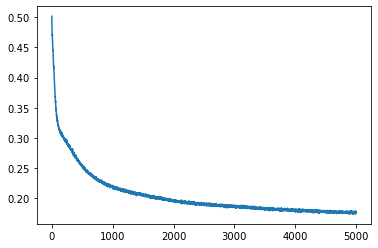

In [15]:
plt.plot(errors)

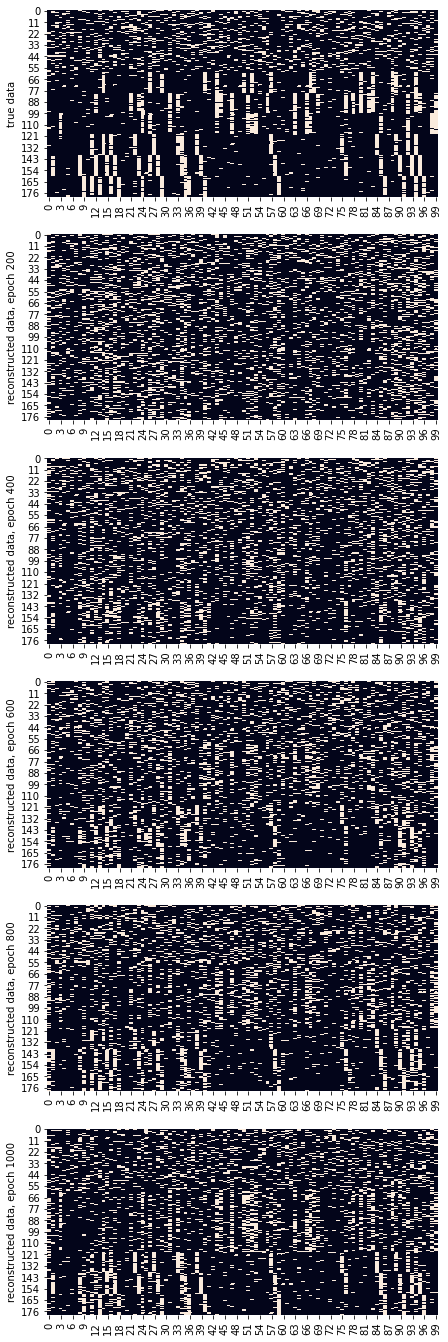

In [24]:
fig, axes = plt.subplots(6, 1, figsize=(7,24))
for i, ax in enumerate(axes):
    if i == 0:
        sns.heatmap(data[:,:100], ax=ax, cbar=False)
        ax.set_ylabel('true data')
    else:
        sns.heatmap(vt_k[i*200, :, :100], ax=ax, cbar=False)
        ax.set_ylabel('reconstructed data, epoch ' + str(200*i))

In [ ]:
torch.rand(N_V, T, )

In [13]:
epochs = torch.arange(n_epochs, dtype=torch.float)


v_inf_mean = torch.mean(v_infer[:, :, 9:, :], (2, 3))
r_inf_mean = torch.mean(r_infer[:, :, 9:, :], (2, 3))
r_mean = torch.mean(r[:, :, 9:, :], (2, 3))
v_mean = torch.mean(data_batches[:, 9:, :], (1, 2))
v_mean_error = torch.zeros(n_epochs)
r_mean_error = torch.zeros(n_epochs)
r_V = torch.zeros(n_epochs)
r_H = torch.zeros(n_epochs)
r_VV = torch.zeros(n_epochs)
r_VH = torch.zeros(n_epochs)
r_HH = torch.zeros(n_epochs)

for epoch in range(n_epochs):
    means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, \
           pw_VV_samples, pw_HH_data, pw_HH_samples, pw_VH_data, pw_VH_samples, \
           r_V[epoch], r_H[epoch], r_VV[epoch], r_VH[epoch], r_HH[epoch] = moments(data_batches.reshape(N_V, T*n_batches), 
                                                r[epoch, :, :, :].reshape(N_H, T*n_batches), 
                                                v_infer[epoch, :, :, :].reshape(N_V, T*n_batches), 
                                                r_infer[epoch, :, :, :].reshape(N_H, T*n_batches))
    v_mean_error[epoch] = mse(v_mean, v_inf_mean[epoch, :])
    r_mean_error[epoch] = mse(r_mean[epoch, :], r_inf_mean[epoch, :])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(epochs, errors)
axes[0].plot(epochs, v_rec_error)
axes[0].plot(epochs, r_rec_error)
axes[0].legend(['CD sampled error', 'visible reconstruction error', 'hidden reconstruction error'])
axes[0].set_xlabel('epochs')

axes[1].plot(epochs, r_V)
axes[1].plot(epochs, r_H)
axes[1].plot(epochs, r_VV)
axes[1].plot(epochs, r_VH)
axes[1].plot(epochs, r_HH)
axes[1].set_title('pearson correlations')
axes[1].legend(['V', 'H', 'VV', 'VH', 'HH'])
axes[1].set_xlabel('epochs')

axes[2].plot(epochs[:150], r_V[:150])
axes[2].plot(epochs[:150], r_H[:150])
axes[2].plot(epochs[:150], r_VV[:150])
axes[2].plot(epochs[:150], r_VH[:150])
axes[2].plot(epochs[:150], r_HH[:150])
axes[2].set_title('pearson correlations first 150 epochs')
axes[2].legend(['V', 'H', 'VV', 'VH', 'HH'])
axes[2].set_xlabel('epochs')

IndexError: too many indices for tensor of dimension 3

### Reconstruction first 100 epochs

Text(0.5, 1.0, "$W'$")

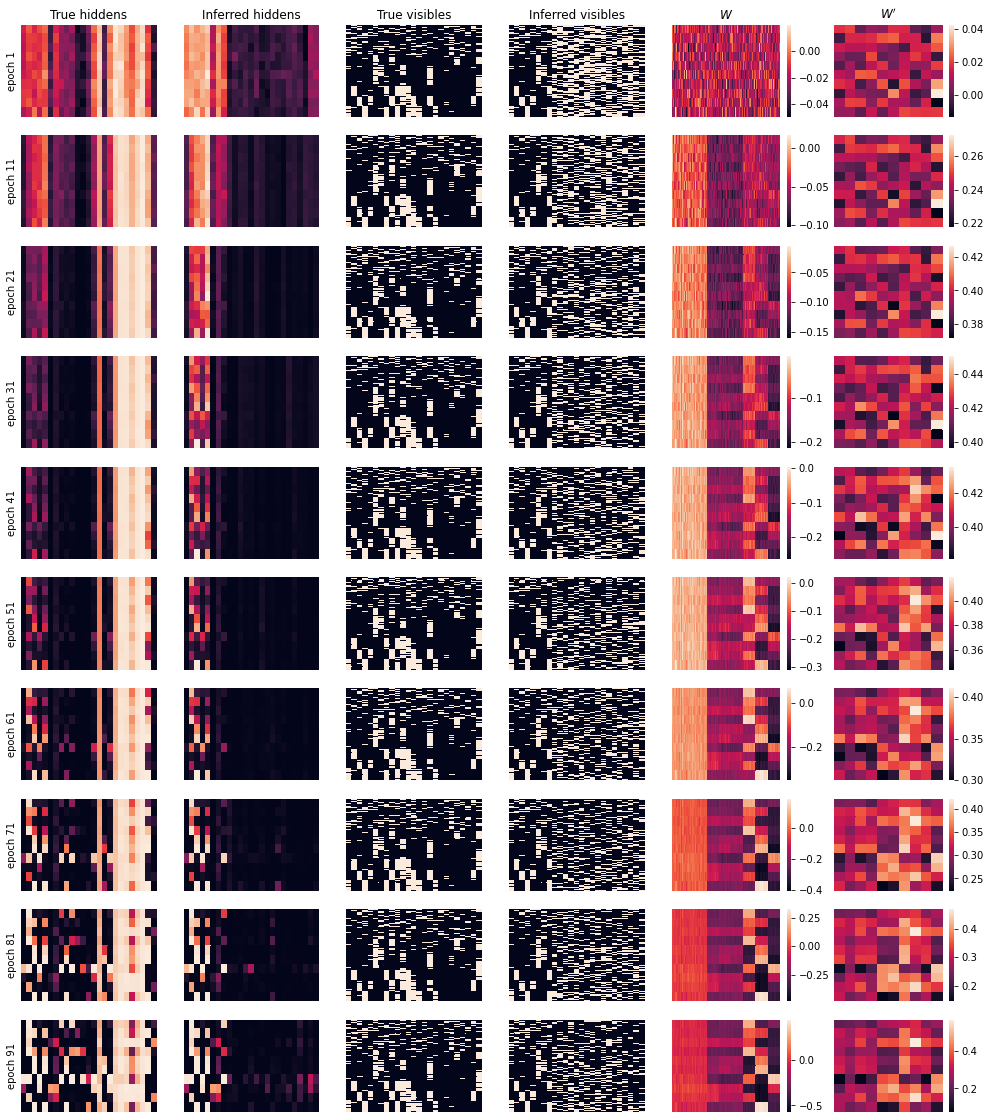

In [79]:
sample = 0
fig, axes = plt.subplots(10, 6, figsize=(17,20))
for i, ax in enumerate(axes):
    sns.heatmap(r[10*i, :, :, sample], ax=ax[0], cbar=False)
    sns.heatmap(r_infer[10*i, :, :, sample], ax=ax[1], cbar=False)
    sns.heatmap(data_batches[:, :, sample], ax=ax[2], cbar=False)
    sns.heatmap(v_infer[10*i, :, :, sample], ax=ax[3], cbar=False)
    sns.heatmap(W[10*i, :, :], ax=ax[4], cbar=True)
    sns.heatmap(W_acc[10*i, :, :], ax=ax[5], cbar=True)
    ax[0].set_ylabel('epoch '+ str(10*i + 1))
    for x in ax: 
        x.set_xticks([])
        x.set_yticks([])
        
axes[0, 0].set_title('True hiddens')
axes[0, 1].set_title('Inferred hiddens')
axes[0, 2].set_title('True visibles')
axes[0, 3].set_title('Inferred visibles')
axes[0, 4].set_title('$W$')
axes[0, 5].set_title('$W\'$')

### Reconstruction every 100 epochs

Text(0.5, 1.0, "$W'$")

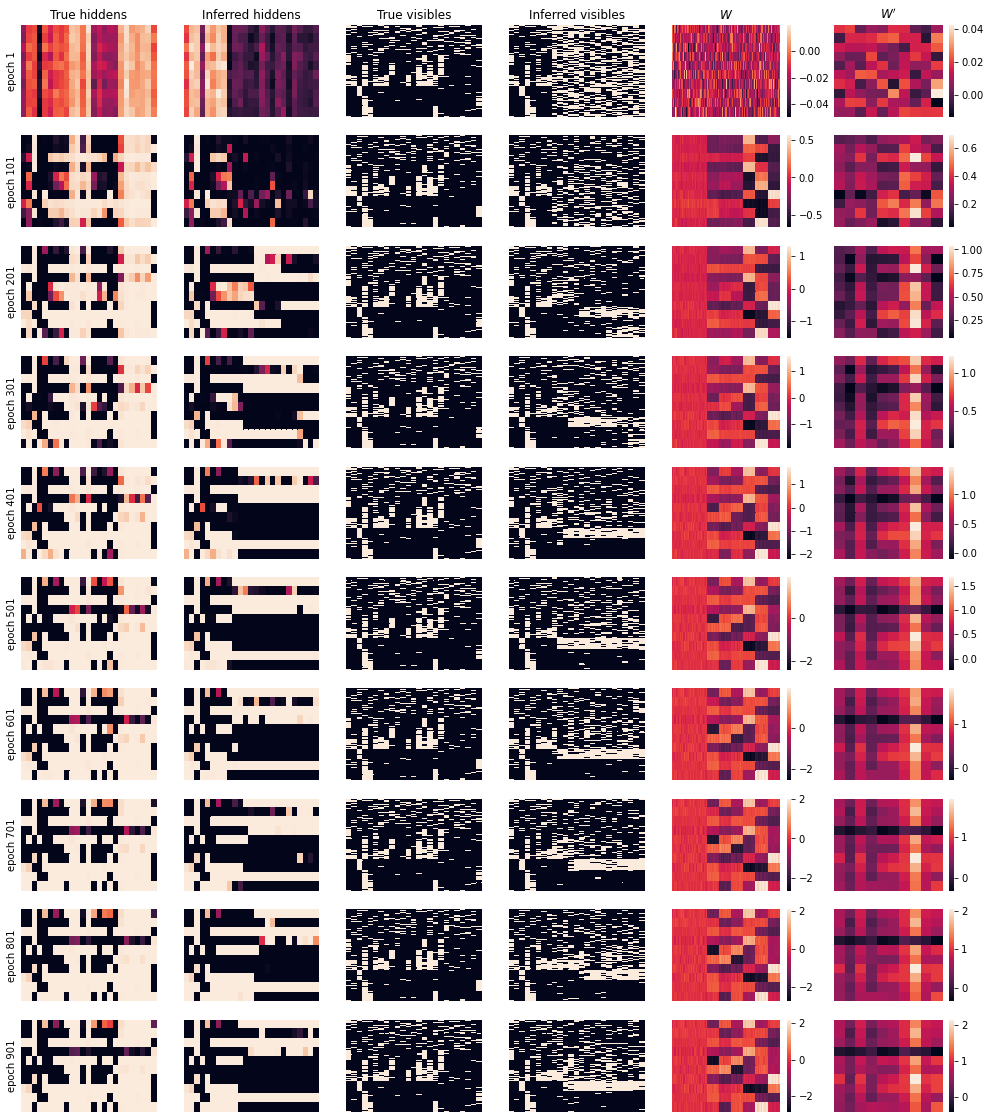

In [82]:
sample = 5
fig, axes = plt.subplots(10, 6, figsize=(17,20))
for i, ax in enumerate(axes):
    sns.heatmap(r[i*100, :, :, sample], ax=ax[0], cbar=False)
    sns.heatmap(r_infer[i*100, :, :, sample], ax=ax[1], cbar=False)
    sns.heatmap(data_batches[:, :, sample], ax=ax[2], cbar=False)
    sns.heatmap(v_infer[i*100, :, :, sample], ax=ax[3], cbar=False)
    sns.heatmap(W[i*100, :, :], ax=ax[4], cbar=True)
    sns.heatmap(W_acc[i*100, :, :], ax=ax[5], cbar=True)
    ax[0].set_ylabel('epoch '+ str(i*100 + 1))
    for x in ax: 
        x.set_xticks([])
        x.set_yticks([])
        
axes[0, 0].set_title('True hiddens')
axes[0, 1].set_title('Inferred hiddens')
axes[0, 2].set_title('True visibles')
axes[0, 3].set_title('Inferred visibles')
axes[0, 4].set_title('$W$')
axes[0, 5].set_title('$W\'$')

There seems to be a sweet spot between 40 and 50 epochs

### Reconstruction epoch 100 - 200

Text(0.5, 1.0, "$W'$")

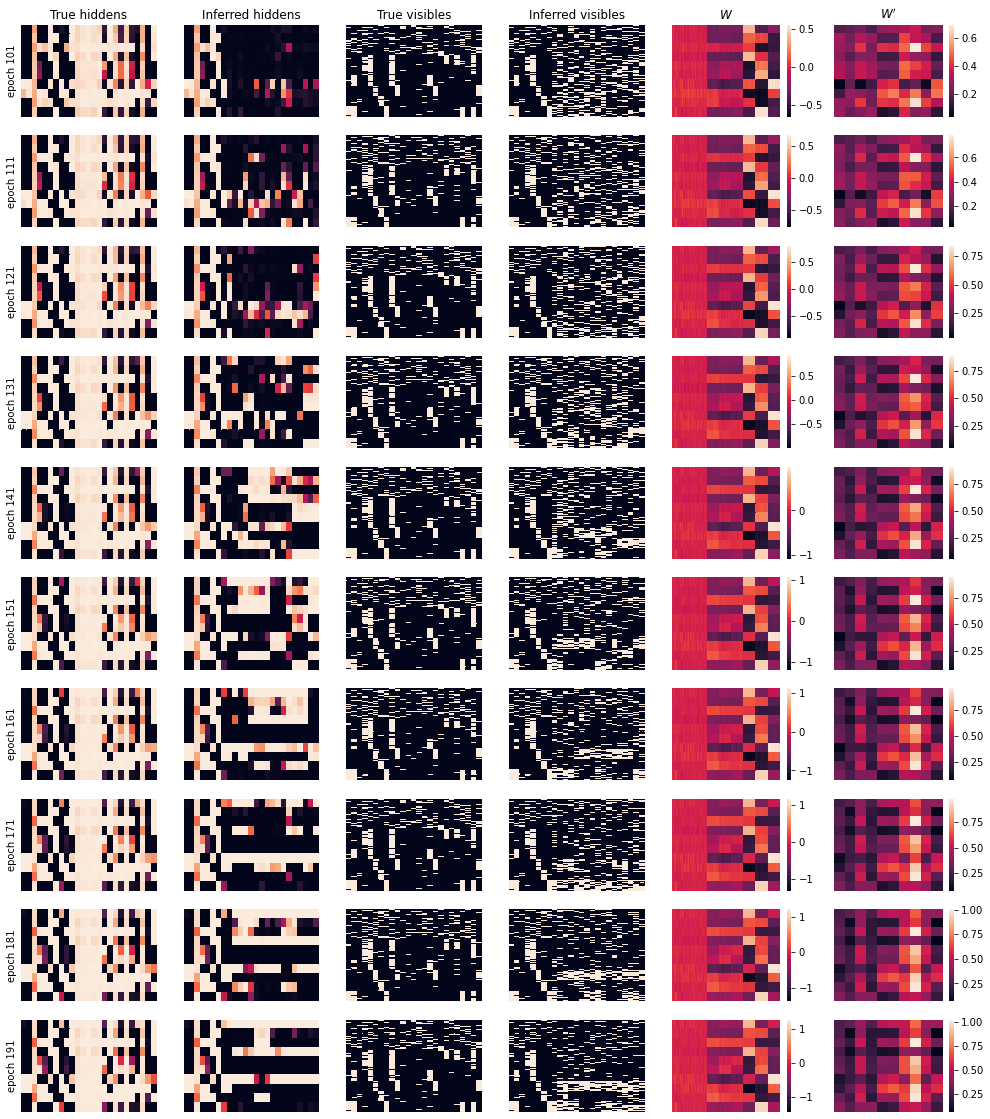

In [66]:
sample = 1
fig, axes = plt.subplots(10, 6, figsize=(17,20))
for i, ax in enumerate(axes):
    sns.heatmap(r[100+10*i, :, :, sample], ax=ax[0], cbar=False)
    sns.heatmap(r_infer[100+10*i, :, :, sample], ax=ax[1], cbar=False)
    sns.heatmap(data_batches[:, :, sample], ax=ax[2], cbar=False)
    sns.heatmap(v_infer[100+10*i, :, :, sample], ax=ax[3], cbar=False)
    sns.heatmap(W[100+10*i, :, :], ax=ax[4], cbar=True)
    sns.heatmap(W_acc[100+10*i, :, :], ax=ax[5], cbar=True)
    ax[0].set_ylabel('epoch '+ str(100+10*i + 1))
    for x in ax: 
        x.set_xticks([])
        x.set_yticks([])
        
axes[0, 0].set_title('True hiddens')
axes[0, 1].set_title('Inferred hiddens')
axes[0, 2].set_title('True visibles')
axes[0, 3].set_title('Inferred visibles')
axes[0, 4].set_title('$W$')
axes[0, 5].set_title('$W\'$')

### Relative contributions of terms to hidden units

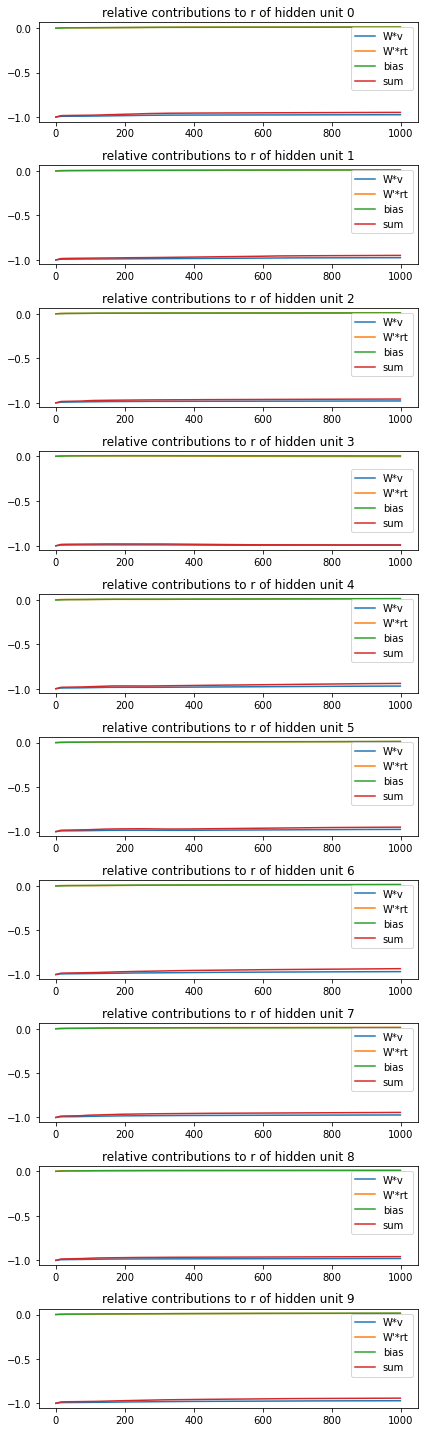

In [67]:
fig, axes = plt.subplots(10, 1, figsize=(6, 20))
epochs = torch.arange(n_epochs)
for i, ax in enumerate(axes):
    tot = torch.abs(v_contribution_r[:, i]) + torch.abs(h_contribution_r[:, i]) + torch.abs(bias[:, i])
    ax.plot(epochs, v_contribution_r[:, i] / tot)
    ax.plot(epochs, h_contribution_r[:, i] / tot)
    ax.plot(epochs, bias[:, i] / tot)
    ax.plot(epochs, (v_contribution_r[:, i] + h_contribution_r[:, i] + bias[:, i]) / tot)
    ax.set_title('relative contributions to r of hidden unit ' + str(i))
    ax.legend(['W*v', 'W\'*rt', 'bias', 'sum'])
    
plt.tight_layout()

### plotting the means of gradient updates

Text(0.5, 1.0, '$db_{init}$')

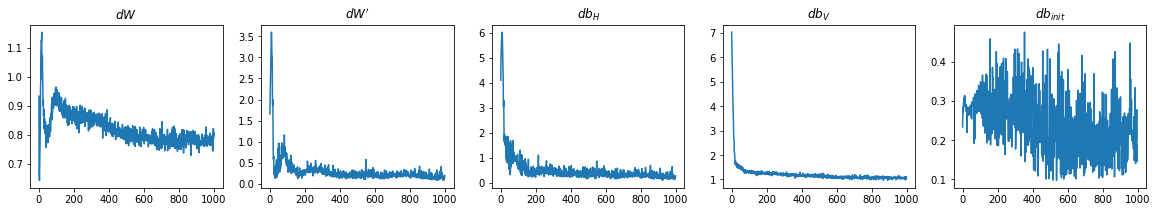

In [68]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
ax[0].plot(torch.mean(torch.abs(dW), (1, 2)))
ax[0].set_title('$dW$')
ax[1].plot(torch.mean(torch.abs(dW_acc), (1, 2)))
ax[1].set_title('$dW\'$')
ax[2].plot(torch.mean(torch.abs(db_H), 1))
ax[2].set_title('$db_H$')
ax[3].plot(torch.mean(torch.abs(db_V), 1))
ax[3].set_title('$db_V$')
ax[4].plot(torch.mean(torch.abs(db_init), 1))
ax[4].set_title('$db_{init}$')

### Plotting the standard deviation of the gradient updates

Text(0.5, 1.0, '$db_{init}$')

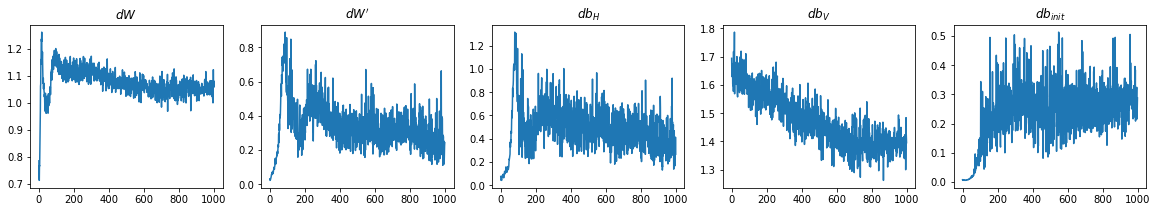

In [69]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
ax[0].plot(torch.std(dW, (1, 2)))
ax[0].set_title('$dW$')
ax[1].plot(torch.std(dW_acc, (1, 2)))
ax[1].set_title('$dW\'$')
ax[2].plot(torch.std(db_H, 1))
ax[2].set_title('$db_H$')
ax[3].plot(torch.std(db_V, 1))
ax[3].set_title('$db_V$')
ax[4].plot(torch.std(db_init, 1))
ax[4].set_title('$db_{init}$')